# Initialization

The GPU can be initialized automatically by importing the `autoinit` module.

In [1]:
import pycuda.autoinit
import pycuda.driver as drv

# GPU attributes

We can easily determine the number of GPU devices in the compute node, and query the properties of each.

In [2]:
for i in range(drv.Device.count()):
    device = drv.Device(i)
    print(f'device {device.name()}')
    print('  device capability: {0}.{1}'.format(*device.compute_capability()))
    for key, value in device.get_attributes().items():
        print(f'  {key}: {value}')

device NVIDIA GeForce RTX 2060 SUPER
  device capability: 7.5
  ASYNC_ENGINE_COUNT: 2
  CAN_MAP_HOST_MEMORY: 1
  CLOCK_RATE: 1650000
  COMPUTE_CAPABILITY_MAJOR: 7
  COMPUTE_CAPABILITY_MINOR: 5
  COMPUTE_MODE: DEFAULT
  CONCURRENT_KERNELS: 1
  ECC_ENABLED: 0
  GLOBAL_L1_CACHE_SUPPORTED: 1
  GLOBAL_MEMORY_BUS_WIDTH: 256
  GPU_OVERLAP: 1
  INTEGRATED: 0
  KERNEL_EXEC_TIMEOUT: 1
  L2_CACHE_SIZE: 4194304
  LOCAL_L1_CACHE_SUPPORTED: 1
  MANAGED_MEMORY: 1
  MAXIMUM_SURFACE1D_LAYERED_LAYERS: 2048
  MAXIMUM_SURFACE1D_LAYERED_WIDTH: 32768
  MAXIMUM_SURFACE1D_WIDTH: 32768
  MAXIMUM_SURFACE2D_HEIGHT: 65536
  MAXIMUM_SURFACE2D_LAYERED_HEIGHT: 32768
  MAXIMUM_SURFACE2D_LAYERED_LAYERS: 2048
  MAXIMUM_SURFACE2D_LAYERED_WIDTH: 32768
  MAXIMUM_SURFACE2D_WIDTH: 131072
  MAXIMUM_SURFACE3D_DEPTH: 16384
  MAXIMUM_SURFACE3D_HEIGHT: 16384
  MAXIMUM_SURFACE3D_WIDTH: 16384
  MAXIMUM_SURFACECUBEMAP_LAYERED_LAYERS: 2046
  MAXIMUM_SURFACECUBEMAP_LAYERED_WIDTH: 32768
  MAXIMUM_SURFACECUBEMAP_WIDTH: 32768
  MAXIMUM_

# GPU arrays

Working with arrays on a GPU is fairly straightforward.

In [2]:
import numpy as np
from pycuda import gpuarray

Create a large array on the nost device.  This is simply a numpy array.

In [4]:
host_data = np.float32(np.random.uniform(size=(50_000_000, )))

Time how long it takes to multiply each element by 2.

In [5]:
%timeit np.float32(2.0)*host_data

29 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
host_data_2 = np.float32(2.0)*host_data

Create a device array, this is a GPU array initialized with the data of the host array.

In [7]:
device_data = gpuarray.to_gpu(host_data)

Time how long it takes to multiply the device array by 2 on the GPU.

In [8]:
%timeit np.float32(2.0)*device_data

11.5 ms ± 29.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Note that the computation on the GPU is approximately twice as fast.

In [9]:
device_data_2 = np.float32(2.0)*device_data

Copy the device data to the host memory into a new numpy array.

In [10]:
from_device_data = device_data_2.get()

Check whether the computation on the host and the device yielded the same results.

In [11]:
all(host_data_2 == from_device_data)

True

# Kernels

A kernel is a function that will be executed on the device. PyCUDA support a number of different kernels, each with its own characteristics.

## Elementwise kernels

In [12]:
from pycuda.elementwise import ElementwiseKernel

An elementwise kernel operates on each individual element of an array independently.  In the example below, each array element is multipliced by 2.
A kernel definition requires three arguments:
1. The signature of the function, so pointers to the input and output array.
1. The body of the function (note the semi-colon), it can have multiple statements.
1. The name of the kernel in the generated code.

### Simple example

In [13]:
kernel_2x = ElementwiseKernel(
    'float *in, float *out',
    'out[i] = 2.0f*in[i];',
    'kernel_2x'
)

Note that the array index `i` is declared by the code generator that creates the CUDA code for the kernel.  You should not declare it yourself.

We create host data, and copy it to the device.

In [14]:
host_in_data = np.float32(np.random.uniform(size=(50_000_000, )))
gpu_in_data = gpuarray.to_gpu(host_in_data)

We also have to create an array to store the results in, and this is done directly on the device.

In [15]:
gpu_out_data = gpuarray.empty_like(gpu_in_data)

Now the kernel can be invoked simply by calling the function `kernel_2x`.

In [16]:
%timeit kernel_2x(gpu_in_data, gpu_out_data)

1.27 ms ± 4.18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Retrieve the result from the device.

In [40]:
host_out_data = gpu_out_data.get()

Note that using the `ElementwiseKernel` is significantly faster than performing the computation inline as in the previous section.

### Multiple arguments

Kernels can have arguments besides the input and output, as well as multiple input arrays, e.g.,

In [41]:
kernel_saxpy = ElementwiseKernel(
    'float *x, float *y, float *r, float alpha',
    'r[i] = alpha*x[i] + y[i];',
    'kernel_saxpy'
)

Create the host data.

In [42]:
x = np.float32(np.random.uniform(size=(50_000_000, )))
y = np.float32(np.random.uniform(size=(50_000_000, )))
alpha = np.float32(0.31)

Move the data to the device.

In [43]:
device_x = gpuarray.to_gpu(x)
device_y = gpuarray.to_gpu(y)
device_r = gpuarray.empty_like(device_x)

Execute the kernel.

In [44]:
%%time
kernel_saxpy(device_x, device_y, device_r, alpha)

CPU times: user 5.2 ms, sys: 16.4 ms, total: 21.6 ms
Wall time: 80.9 ms


Compare to the host.

In [45]:
%%time
r = alpha*x + y

CPU times: user 39.2 ms, sys: 80.9 ms, total: 120 ms
Wall time: 118 ms


In [46]:
np.max(np.abs(r - device_r.get()))

1.1920929e-07

### Mandelbrot set

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
kernel_mandelbrot = ElementwiseKernel('pycuda::complex<float> *z, pycuda::complex<float> c, int *graph, int max_iters',
                                      '''
                                      graph[i] = 0;
                                      while (graph[i] < max_iters && abs(z[i]) < 2.0) {
                                          z[i] = z[i]*z[i] + c;
                                          graph[i]++;
                                      }
                                      ''',
                                      'kernel_mandelbrot')

In [82]:
real = np.linspace(-1.8, 1.8, 4096, dtype=np.float32)
imag = np.linspace(-1.8, 1.8, 4096, dtype=np.float32)
Real, Imag = np.meshgrid(real, imag)
Z = Real + np.complex64(1.0j)*Imag

In [83]:
c = np.complex64(0.4 + 0.6j)

In [91]:
device_Z = gpuarray.to_gpu(Z.reshape((Z.size)))
device_graph = gpuarray.empty((Z.size, ), dtype=np.int32)

In [92]:
kernel_mandelbrot(device_Z, c, device_graph, 255)

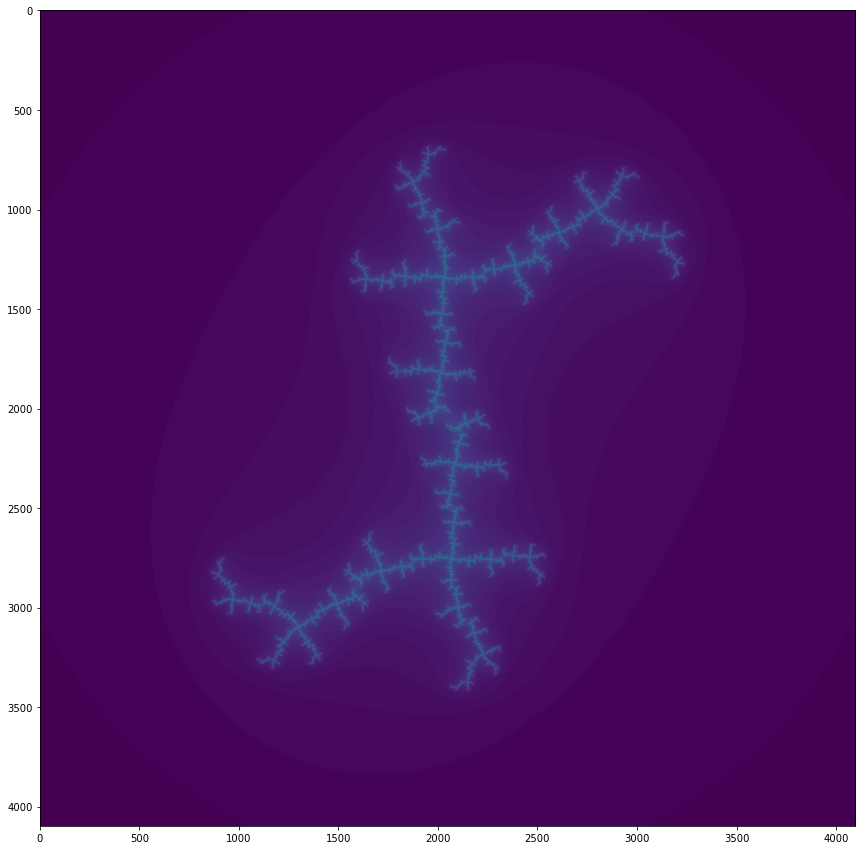

In [97]:
figure, axes = plt.subplots(figsize=(15, 15))
axes.set_aspect('equal')
_ = axes.imshow(device_graph.get().reshape(Z.shape))

## Reduction kernel

Besides pointwise operations, reductions are also useful, and pyCUDA has a specific kernel for that.

In [47]:
from pycuda.reduction import ReductionKernel

To construct a reduction kernel, we have to specify
1. the type of the result,
1. the neutral element of the reduction operator, e.g., 0 for a sum,
1. the reduction expression, the operands are represented by `a` and `b` (C code),
1. the map expression based on the arguments (C code),
1. the argument string (C code),
1. the name of the kernel, typically the same as the Python variable it is assigned to.

In [49]:
kernel_dot_product = ReductionKernel(np.float32, neutral=np.float32(0.0), reduce_expr='a + b',
                                     map_expr='vec1[i]*vec2[i]', arguments='float *vec1, float *vec2',
                                     name='kernel_dot_product')

The kernel above will compute the dot product of two vectors.

We define two vectors on the host, and transfer them to the device.

In [50]:
v1 = np.float32(np.random.uniform(size=(1_000_000, )))
v2 = np.float32(np.random.uniform(size=(1_000_000, )))

In [52]:
device_v1 = gpuarray.to_gpu(v1)
device_v2 = gpuarray.to_gpu(v2)

Now we can execute the kernel on the device.

In [57]:
device_result = kernel_dot_product(device_v1, device_v2)

In [66]:
device_result.get()

array(250032.45, dtype=float32)

Note that the result is a 0-dimensional numpy array, which you can treat as if it were a scalar.

The result is the same as the equivalant computation on the host.

In [54]:
np.sum(v1*v2)

250032.42

## Source module

The most general way to write CUDA code for pyCUDA is by writing source modules.

In [3]:
from pycuda.compiler import SourceModule

The module below defines two device constants, `degree` and `a` which denote the degree and coefficients of a polynomial function that is defined by the device function `polynom`.  These constants and the function can only be used on the device. The kernel is `poly_kernel` and can, after being compiled, be retrieved from the source module and called from Python.

In [4]:
source_code = '''
    
    __constant__ int degree = 2;
    __constant__ float a[] = {1.0f, -2.0f, -0.5f};
    
    __device__ float polynom(float x) {
        float result = 0.0f;
        float factor = 1.0f;
        for (int i = 0; i <= degree; ++i) {
            result += a[i]*factor;
            factor *= x;
        }
        return result;
    }
    
    __global__ void poly_kernel(float *in, float *out, int part_size) {
        int i = threadIdx.x;
        int offset = part_size*i;
        for (int j = 0; j < part_size; ++j) {
            out[offset + j] = polynom(in[offset + j]);
        }
    }

'''

In [5]:
poly_kernel = SourceModule(source_code).get_function('poly_kernel')

We set the block size and the number of array elements to be processed by each CUDA thread.

In [6]:
block_size, part_size = 512, 1024

We create the host data, and create the required device arrays.

In [8]:
v = np.float32(np.random.uniform(size=(block_size*part_size, )))
device_v = gpuarray.to_gpu(v)
device_p = gpuarray.empty_like(device_v)

Now we can call the kernel, specifying both the block and the grid dimensions.  We use a single 1D block with 512 threads.

In [9]:
poly_kernel(device_v, device_p, np.int32(part_size), block=(block_size, 1, 1), grid=(1, 1, 1))

We can now retrieve the result from the device and check whether it is correct.

In [10]:
p = device_p.get()

In [13]:
np.allclose(p, 1.0 - 2.0*v - 0.5*v**2, atol=1.0e-6)

True